## Long short-term memory autoencoder

*Autoencoder* — архитектура нейронной сети, которая по входным данным получает выходные данные той же размерности. В зависимости от типа может иметь один или несколько скрытых слоев. Автоенкодеры имеют два модуля: кодировщик (encoder) и декодировщик (decoder). Кодировщик работает со здоровыми данными и изучает как устроены нормальные рабочие процессы системы, а затем сжимает данные в скрытое представление. Декодировщик пытается восстановить из этого представления выходные данные. Все что на выходе не соответсвует нормальному состоянию системы будет определено как аномалия. **Цель** — получить на выходном слое отклик, наиболее близкий к входному.

<img src="./img/ae_scheme.png" alt="Drawing" style="width: 600px; height: 350px"/>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')
from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE

### Process data

In [2]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)

### Make model

In [3]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 1
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AE_Predictor(Predictor):
    def make_prediction(self, df):
        ss = StandardScaler()
        x_train = np.array(ss.fit_transform(df[:conf.train_size].drop(['anomaly','changepoint'], axis=1)))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_AE()
        model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)
        
        health_r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_train) - x_train), axis=1), axis=1))
        UCL = health_r.quantile(conf.Q)
        
        x_test = df.drop(['anomaly','changepoint'], axis=1)
        x_test = np.array(ss.transform(x_test))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))        
        anomalous_data = r > (3/2 * UCL)
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS - 1, len(x_test) - conf.TIME_STEPS + 1):
            if np.all(anomalous_data[data_idx - conf.TIME_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx - int(conf.TIME_STEPS // 6))
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction
        


In [4]:
prediction = LSTM_AE_Predictor().make_prediction(df)

36/36 [==============================] - 10s 100ms/step - loss: 0.9081


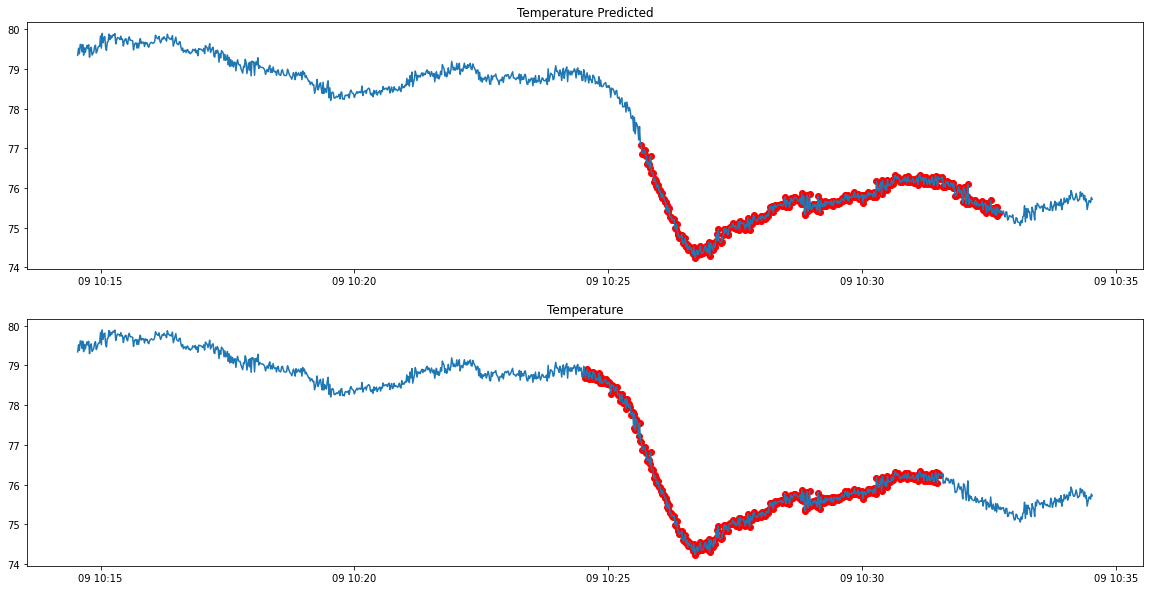

In [5]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [6]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.8387096774193549
FAR = 0.08981233243967829
MAR = 0.1571072319201995


Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 15s 174ms/step - loss: 1374583914496.0000
F1 = 0.7641727092946605

FAR = 0.10041346721795628

MAR = 0.26501822792835633



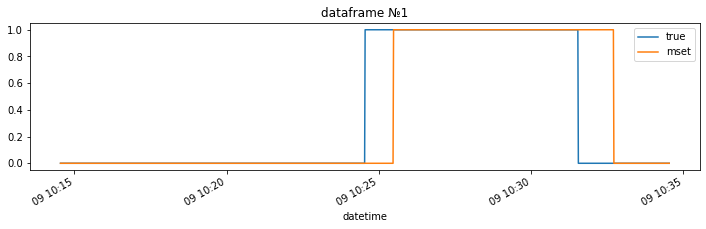

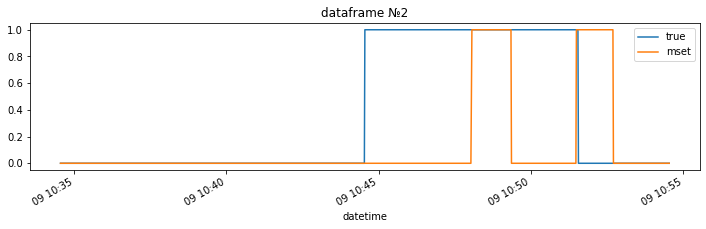

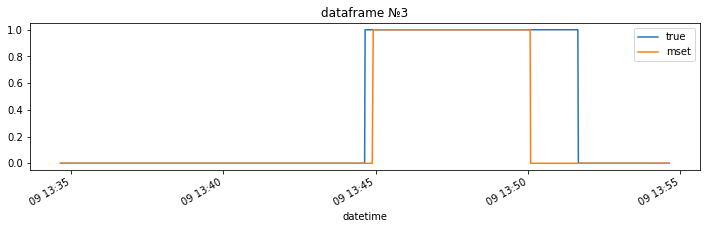

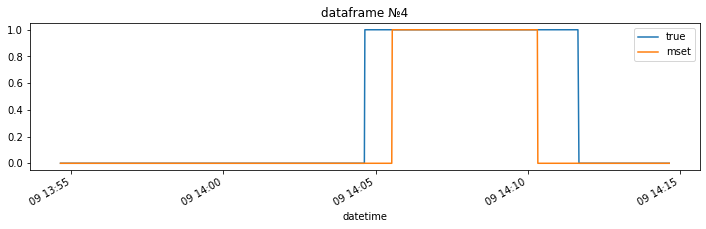

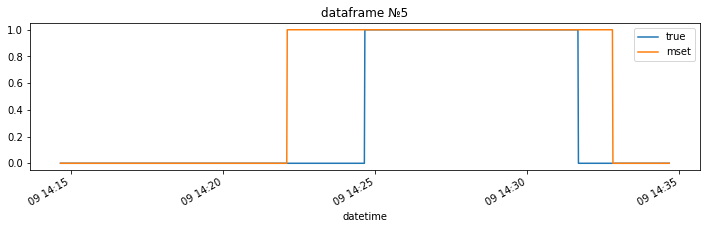

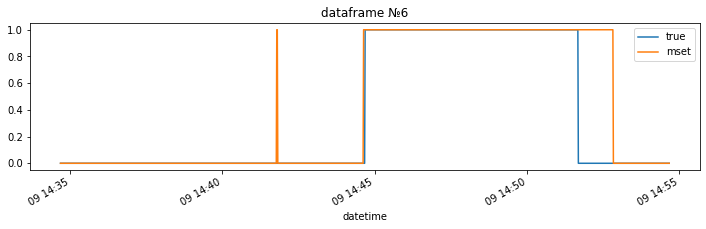

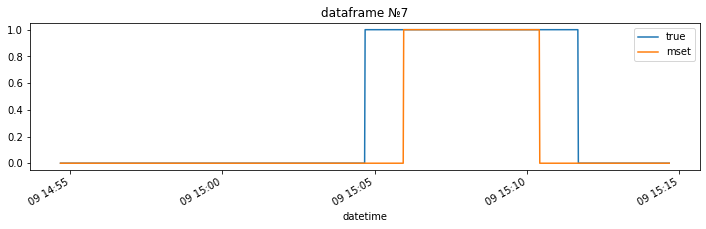

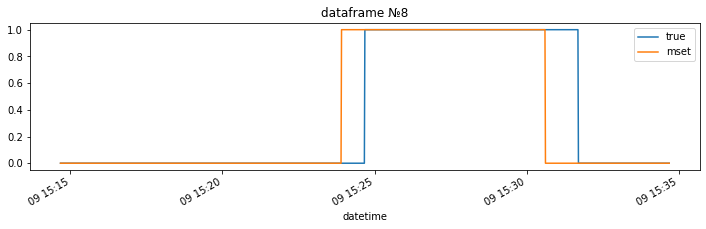

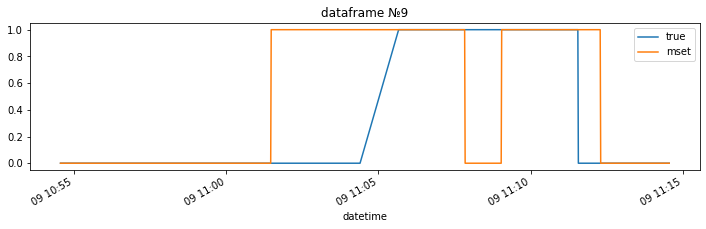

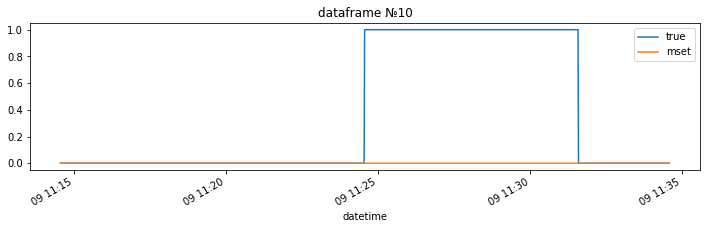

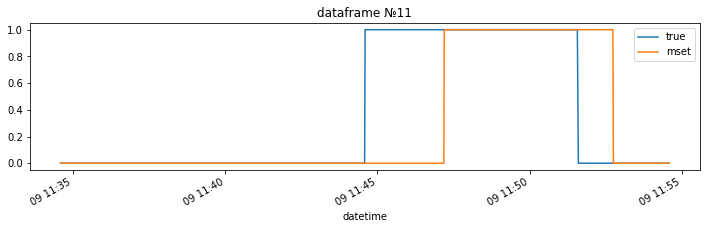

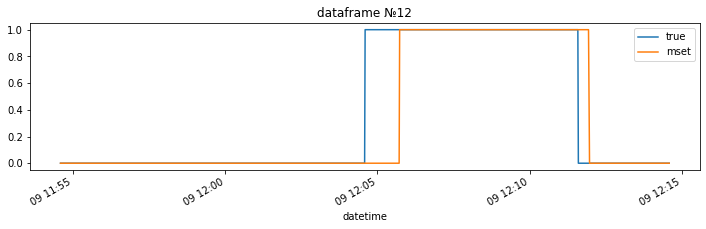

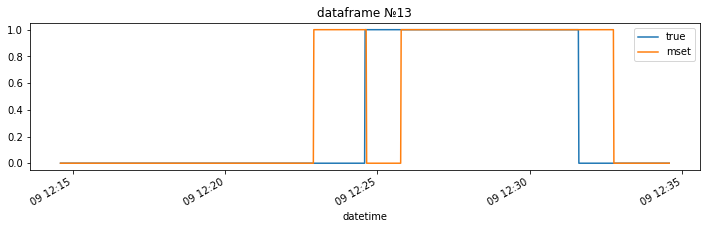

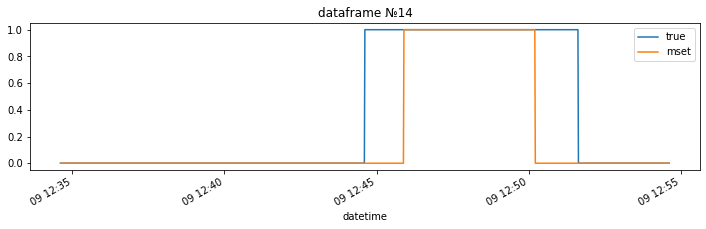

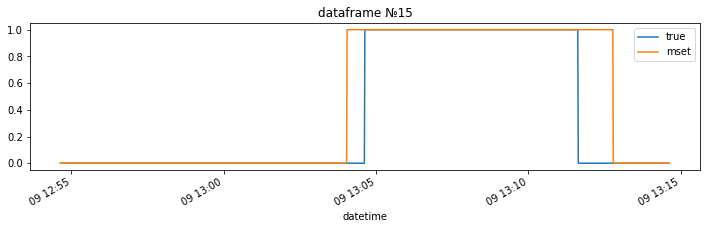

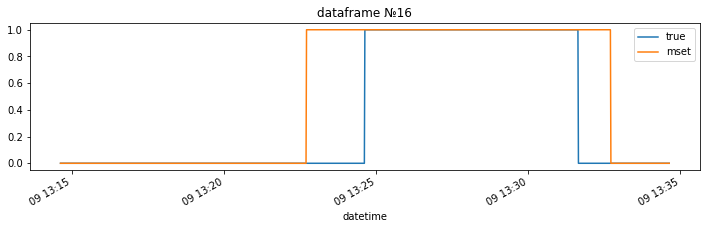

In [16]:
from utils.data import load_df

# anomaly_types = ("valve1", "valve2", "other", )
anomaly_types = ("valve1", )

anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = LSTM_AE_Predictor()
p = Pipeline()

# list_of_df, _ = load_df("./data/", "valve1")
# anomaly_groups={"valve1":list_of_df[:1]}
# metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [19]:
from IPython.display import display, Markdown, Latex
def show_score_table(metrics:dict) -> None:
    columns = list(metrics.keys())
    metrics_arr = np.array(list(metrics.values()))
    metric_names = ["F1", "FAR", "MAR"]
    table = []
    table.append(" | ".join(["metric"] + columns))
    table.append(" | ".join(["---" for _ in range(len(columns) + 1)]))
    for i in range(metrics_arr.shape[-1]):
        row = metrics_arr[:, i]
        table.append(f"{metric_names[i]} |" + " | ".join(map(lambda x: str(round(x, 2)), row)))
    table_str = "\n".join(table)    
    display(Markdown(table_str))
    
show_score_table(metrics)

metric | valve1
--- | ---
F1 |0.76
FAR |0.1
MAR |0.27